## **Answer 1:**

In [98]:
import numpy as np
import matplotlib.pyplot as plt

In [99]:
import math

In [100]:
from timeit import default_timer as timer

In [101]:
np.random.seed(1000)


In [102]:
A = np.random.randn(1000,10)

In [103]:
A.shape

(1000, 10)

In [104]:
epsilon=np.random.randn(1000,1)

In [105]:
epsilon.shape

(1000, 1)

In [106]:
x=[]
for i in range(1,11):
  if i%2==0:
    x.append(np.random.uniform(i,i+1))
  if i%2!=0:
    x.append(np.random.uniform(-i-1,-i))
print(x)


[-1.5598060982531905, 2.3304600657948655, -3.6795264016693583, 4.690106332295438, -5.791543695407358, 6.066830606319292, -7.250688337950498, 8.29645037615345, -9.919538982700145, 10.753574141825613]


In [107]:
x_bar=np.array(x)

In [108]:
x_bar=x_bar.reshape(10,1)


In [109]:
x_bar.shape

(10, 1)

In [110]:
print(x_bar)

[[-1.5598061 ]
 [ 2.33046007]
 [-3.6795264 ]
 [ 4.69010633]
 [-5.7915437 ]
 [ 6.06683061]
 [-7.25068834]
 [ 8.29645038]
 [-9.91953898]
 [10.75357414]]


In [111]:
A_x = A@x_bar

In [112]:
A_x.shape

(1000, 1)

In [113]:
np.matmul(A,x_bar).shape

(1000, 1)

In [114]:
y = A_x + epsilon

In [115]:
y.shape

(1000, 1)

In [116]:
def evalf(x,n):
  assert type(x) is np.ndarray and len(x)==n
  f_val = np.linalg.norm(A@x - y)
  f_val = f_val**(2)
  f_val = (0.5)*f_val
  return f_val

In [117]:
x = np.array([0 for i in range(10)])
evalf(x,10)

253074145.7869687

In [118]:
def evalg(x,n):
  assert type(x) is np.ndarray 
  assert len(x) == n
  return A.T@ (np.matmul(A, x) - y)

In [119]:
evalg(x,10).shape

(10, 1000)

In [120]:
def evalh(x,n):
  assert type(x) is np.ndarray 
  assert len(x) == n 
  return A.T @ A

# **Answer 2:**

In [121]:
BACKTRACKING_LINE_SEARCH = 1

In [122]:
def compute_B_k(s, y, B_k, n):
  assert type(s) is np.ndarray and len(s) == n
  assert type(B_k) is np.ndarray and len(y) == n 
  mu = 1 / np.dot(np.squeeze(np.asarray(y)), np.squeeze(np.asarray(s)))
  I = np.identity(n)
  a_1 = np.outer(np.multiply(mu, s), y.T)
  a_2 = np.outer(np.multiply(mu, y), s.T)
  b_k = np.add(np.matmul(np.matmul(I - a_1, B_k), I - a_2), np.outer(np.multiply(mu, s), s.T) )
  return b_k

In [125]:
#Here, we are computing D_k
def compute_D_k(x,n):
  assert type(x) is np.ndarray and len(x) == n
  if np.linalg.det(evalh(x,n)) == 0:
    raise ValueError('Determinant of Hessian is zero')
  return np.linalg.inv(evalh(x,n))

In [126]:
#Here, we are computing steplength with backtracking scaled direction
def compute_steplength_backtracking_scaled_direction(x, gradf, alpha_start, rho, gamma, B_k): 
  assert type(x) is np.ndarray
  assert type(gradf) is np.ndarray
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  n = len(x)
  alpha = alpha_start
  p = - gradf 
  D_k = B_k
  while evalf(x + alpha*np.matmul(D_k,p), n) > evalf(x, n) + gamma * alpha* (np.matmul(np.matrix.transpose(gradf), np.matmul(D_k,p)) ):
    alpha = alpha * rho
  return alpha  

In [127]:
#Here, we are finding minimum value using Newton’s method implemented with backtracking line search
def find_minimizer_Newton(start_x, n, tol, line_search_type, *args):
  assert type(start_x) is np.ndarray and len(start_x) == n
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n)
  h_x = evalh(x,n)
  x_iter = []
  if line_search_type == BACKTRACKING_LINE_SEARCH:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  step_length = 1.0
  while (np.linalg.norm(g_x) > tol): 
    D_k = np.linalg.inv(evalh(x, n))
    step_length = compute_steplength_backtracking_scaled_direction(x, g_x, alpha_start, rho, gamma, D_k)

    x = np.subtract(x, np.multiply(step_length,np.matmul(D_k, g_x))) #update x = x - step_length*g_x
    x_iter.append(x)
    k += 1 #increment iteration
    g_x = evalg(x, n) #compute gradient at new point
  return x, x_iter

In [131]:
n = 10
my_start_x = np.array([0 for i in range(10)])
my_start_x = my_start_x.reshape(10,1)
my_tol  = 10**(-4)
alpha =0.99
rho=0.5
gamma=0.5

x_arr = []
f_arr = []
print(" Newton's Method : ")
time1 = timer()
x_star_newton , x_k = find_minimizer_Newton(my_start_x, 10, my_tol, BACKTRACKING_LINE_SEARCH, alpha , rho, gamma)
time2 = timer()
for i in range(len(x_k)-1):
  x_arr.append(math.log(np.linalg.norm(x_k[i] - x_star_newton)))
  f_arr.append(math.log(np.linalg.norm(evalf(x_k[i],n) - evalf(x_star_newton,n))))
print("x_star:", x_star_newton, "\nx_bar:", x_bar)
print("f_star:", evalf(x_star_newton,n), "\nf_bar:", evalf(x_bar,n))
print("Time taken by Newton's method: ", time2-time1)

 Newton's Method : 
x_star: [[-1.52615747]
 [ 2.35933586]
 [-3.71408745]
 [ 4.65508607]
 [-5.79228265]
 [ 6.05590254]
 [-7.25518888]
 [ 8.32369299]
 [-9.87348466]
 [10.71878165]] 
x_bar: [[-1.5598061 ]
 [ 2.33046007]
 [-3.6795264 ]
 [ 4.69010633]
 [-5.7915437 ]
 [ 6.06683061]
 [-7.25068834]
 [ 8.29645038]
 [-9.91953898]
 [10.75357414]]
f_star: 504.5963652036184 
f_bar: 508.51427768443995
Time taken by Newton's method:  0.005215004000092449


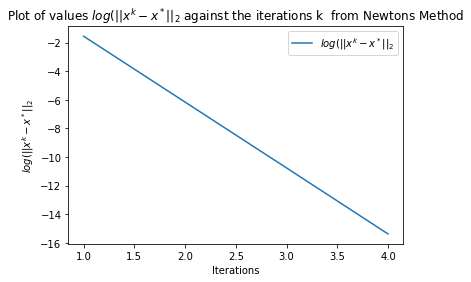

In [132]:
plt.plot([i+1 for i in np.arange(len(x_arr))], x_arr,label=r'$ $')
plt.title(r'Plot of values $log(||x^k - x^*||_2$ against the iterations k  from Newtons Method')
plt.xlabel('Iterations')
plt.ylabel(r'$log(||x^k - x^*||_2$')
plt.legend(['$log(||x^k - x^*||_2$'])
plt.show()

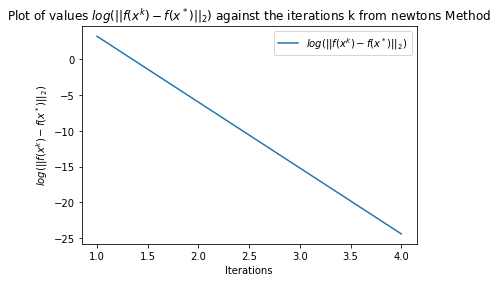

In [133]:
plt.plot([i+1 for i in np.arange(len(f_arr))], f_arr,label=r'$ $')
plt.title(r'Plot of values $log(||f(x^k) - f(x^*)||_2)$ against the iterations k from newtons Method')
plt.xlabel(r'Iterations')
plt.ylabel(r'$log(||f(x^k) - f(x^*)||_2)$')
plt.legend([r'$log(||f(x^k) - f(x^*)||_2)$'])
plt.show()

The condition:

 Q-Linear :$\frac{||x^{k+1} - x^*||_2}{||x^{k} - x^*||_2}\leq r$, 
 
where $r\in(0,1)$

On taking log both sides, we get


$$log(||x^{k+1} - x^*||_2)-log(||x^k - x^*||_2)\leq log(r)$$


Though $r\in (0,1)$

So $log(r)< 0$ 

So, the condition of Q-Linear becomes:


$$log(||x^{k+1} - x^*||_2)-log(||x^k - x^*||_2) < 0$$

From the above plots, we can observe that:

$log(||x^{k+1} - x^*||_2)-log(||x^k - x^*||_2)$ is negative.


On concluding, I can say that the Convergence of the given| function is Q-Linear.

# **Answer 3:**

In [149]:
#Here, we are finding minimum value using BFGS method implemented with backtracking line search
def find_minimizer_BFGS_scaling(start_x, n, tol, line_search_type, *args):
 
  assert type(start_x) is np.ndarray and len(start_x) == n 
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n)

  if line_search_type == BACKTRACKING_LINE_SEARCH:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])

  k = 0
  B_k = np.identity(n)
  x_prev = x
  x_itr = []
  while (np.linalg.norm(g_x) > tol):
    step_length = compute_steplength_backtracking_scaled_direction(x_prev, g_x, alpha_start, rho, gamma, B_k)
    x_new = np.subtract(x_prev, np.multiply(step_length, np.matmul(B_k,g_x))) 
    g_x = evalg(x_new,n)
    s = np.subtract(x_new, x_prev)
    y = np.subtract(evalg(x_new,n), evalg(x_prev,n)) 
    B_k = compute_B_k(s, y, B_k, n)
    x_prev = x_new
    k += 1
    x_itr.append(x_new)
  return x_new,x_itr

In [150]:
n=10
x_start=np.array([0 for i in range(10)]).reshape(10,1)
alpha_start=0.99
rho=0.5
gamma=0.5
my_tol= 1e-4
x_bfgs = []
f_bfgs = []
print("BFGS Method: ")
time1_bfgs = timer()
x_star_bfgs,x_k1 = find_minimizer_BFGS_scaling(x_start, n, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
time2_bfgs = timer()
print("x_star:", x_star_bfgs, "\nx_bar:", x_bar)
print("f_star:", evalf(x_star_bfgs,n), "\nf_bar:", evalf(x_bar,n))
print("Time taken by BFGS: ", time2_bfgs - time1_bfgs)
for i in range(len(x_k1)-1):
  x_bfgs.append(math.log(np.linalg.norm(x_k1[i] - x_star_bfgs)))
  f_bfgs.append(math.log(np.linalg.norm(evalf(x_k1[i],n) - evalf(x_star_bfgs,n))))

BFGS Method: 
x_star: [[-1.52615747]
 [ 2.35933586]
 [-3.71408745]
 [ 4.65508607]
 [-5.79228263]
 [ 6.05590254]
 [-7.25518887]
 [ 8.32369297]
 [-9.87348465]
 [10.71878164]] 
x_bar: [[-1.5598061 ]
 [ 2.33046007]
 [-3.6795264 ]
 [ 4.69010633]
 [-5.7915437 ]
 [ 6.06683061]
 [-7.25068834]
 [ 8.29645038]
 [-9.91953898]
 [10.75357414]]
f_star: 504.5963652036191 
f_bar: 508.51427768443995
Time taken by BFGS:  0.032443178999528755


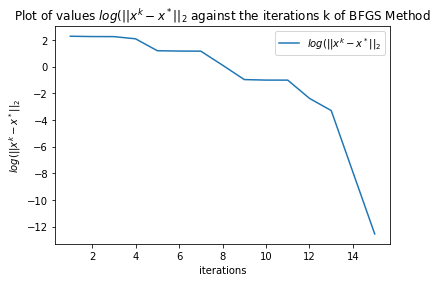

In [151]:
plt.plot([i+1 for i in np.arange(len(x_bfgs))], x_bfgs,label=r'$ $')
plt.title('Plot of values $log(||x^k - x^*||_2$ against the iterations k of BFGS Method')
plt.xlabel('iterations')
plt.ylabel('$log(||x^k - x^*||_2$')
plt.legend([r'$log(||x^k - x^*||_2$'])
plt.show()

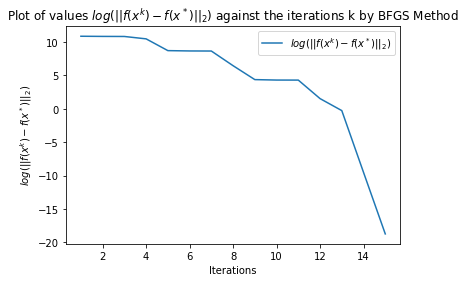

In [152]:
plt.plot([i+1 for i in np.arange(len(f_bfgs))], f_bfgs,label=r'$ $')
plt.title(r'Plot of values $log(||f(x^k) - f(x^*)||_2)$ against the iterations k by BFGS Method')
plt.xlabel(r'Iterations')
plt.ylabel(r'$log(||f(x^k) - f(x^*)||_2)$')
plt.legend([r'$log(||f(x^k) - f(x^*)||_2)$'])
plt.show()

In the above both the plots, I can observe that for very large values of iterations the value of $log(||x^{k+1} - x^*||_2)-log(||x^k - x^*||_2)$ becomes negative, so the convergence of function is Q-Linear.

## **Answer 4:**

In [153]:
print("Taken time by Newton's method: ", time2-time1)
print("Taken time by BFGS method: ", time2_bfgs - time1_bfgs)

Taken time by Newton's method:  0.005215004000092449
Taken time by BFGS method:  0.032443178999528755


From the output of the above cell, I can clearly conclude that time taken by newton's method is little less than the time taken by BFGS method and the value of optimizer is almost equal for both the methods and function value $x^*$ and $\bar{x}$ is not differ so much. Therefore I can say that Newtons method is faster than BFGS method.